In [43]:
import os
import numpy as np
import pandas as pd
from tscv import GapRollForward

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# specify load and weather data details
DATA_PATH = '../data'
REGION = 'sa'
DATA_FILENAME = 'merged2.csv'
OBS_PER_DAY = 24
X_EXCLUDE = ['datetime', 'net_load', 'total_load']
HOLIDAY_FILENAME = 'holidays2017_2024.csv'

# for convenience below
obs = np.arange(1000) * OBS_PER_DAY

# specify methodology and model parameters
TRAIN_BEGIN = '2018-03-07'
TRAIN_MIN_SIZE = obs[365]   # change for expanding window
TRAIN_MAX_SIZE = obs[365]   # change for expanding window (np.inf)
TEST_MIN_SIZE = obs[7]
TEST_MAX_SIZE = obs[7]
TEST_FINAL_N = None         # set to None for rolling test window, or n to test final observations
ROLL_SIZE = obs[30]

# extract holidays from file
holiday_df = pd.read_csv(os.path.join(DATA_PATH, HOLIDAY_FILENAME), dtype='str')
holiday_df['Date'] = holiday_df['Date'].astype('datetime64[ns]')

# import and preprocess data
full_data_path = os.path.join(DATA_PATH, REGION, DATA_FILENAME)
df = pd.read_csv(os.path.relpath(full_data_path))
df['datetime'] = df['datetime'].astype('datetime64')
dt = df['datetime'].dt
df['year'] = dt.year
df['month'] = dt.month
df['day'] = dt.day
df['hour'] = dt.hour
df['minute'] = dt.minute
df['dow'] = dt.day_of_week
df['week'] = dt.isocalendar().week

holidays = holiday_df.loc[holiday_df['Jurisdiction'] == REGION, ['Date', 'Holiday Name']]
df['holiday'] = dt.date.isin(holidays['Date'].dt.date).astype('int')

df_subset = df[TRAIN_BEGIN <= df['datetime']]

# compute X and y column indices
X_cols = np.setdiff1d(df.columns.values, X_EXCLUDE)
X_inds = sorted(df.columns.get_indexer_for(X_cols))
y_ind = df.columns.get_loc('net_load')

X = df_subset.iloc[:, X_inds]
y = df_subset.iloc[:, y_ind]

# create train/test window strategy
tscv = GapRollForward(min_train_size=TRAIN_MIN_SIZE, max_train_size=TRAIN_MAX_SIZE,
                    min_test_size=TEST_MIN_SIZE, max_test_size=TEST_MAX_SIZE,
                    roll_size=ROLL_SIZE)
print(sum(1 for i in tscv.split(df_subset)), 'CV folds')

49 CV folds


In [44]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

params = [
    {},
    {'learning_rate': [0.5, 1]},
    {'max_iter': [200, 400]},
    {'max_leaf_nodes': [None, 50]},
    {'interaction_cst': ['pairwise']},
    {'l2_regularization': [0.1, 0.25, 0.5]},
]
param_distributions = {
    "max_iter": [100, 500, 1000],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
    "interaction_cst": [None, 'pairwise'],
    "l2_regularization": loguniform(0.01, 1)
}

search = RandomizedSearchCV(
    HistGradientBoostingRegressor(), 
    param_distributions = param_distributions, 
    cv = tscv.split(df_subset), 
    n_jobs = -1, 
    n_iter = 20,
    random_state = 0,
    refit = 'neg_mean_absolute_percentage_error',
    scoring = ['neg_mean_absolute_percentage_error', 
               'neg_mean_absolute_error',
               'neg_root_mean_squared_error',
               'r2']
)
search.fit(X, y)


RandomizedSearchCV(cv=<generator object GapRollForward.split at 0x7fef50121dd0>,
                   estimator=HistGradientBoostingRegressor(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'interaction_cst': [None, 'pairwise'],
                                        'l2_regularization': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fef40c38940>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fef3a86d640>,
                                        'max_iter': [100, 500, 1000],
                                        'max_leaf_nodes': [2, 5, 10, 20, 50,
                                                           100]},
                   random_state=0, refit='neg_mean_absolute_percentage_error',
                   scoring=['neg_mean_absolute_percentage_error',
                            'neg_mean_absolute_error',
                            'neg_root_mean_squared_error', 'r2'])

In [45]:

rename_d = {
    "mean_test_neg_mean_absolute_error": 'MAE', 
    "std_test_neg_mean_absolute_error": 'std_AE',
    "mean_test_neg_mean_absolute_percentage_error": 'MAPE', 
    "std_test_neg_mean_absolute_percentage_error": 'std_APE',
    "mean_test_neg_root_mean_squared_error": 'RMSE', 
    "std_test_neg_root_mean_squared_error": 'std_MSE',
    "mean_test_r2": 'R2',
    "std_test_r2": 'std_R2'
}
results_df = pd.DataFrame(search.cv_results_).rename(rename_d, axis=1)
results_df[['MAPE', 'MAE', 'RMSE']] = -results_df[['MAPE', 'MAE', 'RMSE']]
results_df[['MAPE', 'std_APE']] = results_df[['MAPE', 'std_APE']] * 100
results_df[['param_' + k for k in param_distributions] + list(rename_d.values())].sort_values('MAPE').round(2)

,param_max_iter,param_max_leaf_nodes,param_learning_rate,param_interaction_cst,param_l2_regularization,MAE,std_AE,MAPE,std_APE,RMSE,std_MSE,R2,std_R2
12,500,10,0.053385,None,0.042742,74.15,23.73,6.45,2.67,97.84,32.09,0.89,0.07
10,500,5,0.248463,pairwise,0.074828,77.24,25.16,6.54,2.61,100.15,31.08,0.88,0.08
7,100,10,0.353563,pairwise,0.033815,79.02,24.65,6.65,2.34,102.65,31.86,0.88,0.08
19,1000,20,0.03678,pairwise,0.011978,79.87,30.34,6.81,3.02,103.41,38.14,0.87,0.09
11,1000,20,0.021969,pairwise,0.202432,81.50,30.73,6.94,3.09,105.39,38.50,0.87,0.09
0,500,20,0.488126,None,0.153352,80.63,28.15,7.06,3.47,107.17,39.56,0.87,0.10
9,1000,10,0.638553,None,0.05929,85.03,36.90,7.23,3.50,110.87,44.93,0.84,0.17
4,100,10,0.820938,pairwise,0.054511,88.36,33.92,7.42,3.22,114.59,43.22,0.84,0.12
17,500,20,0.015567,pairwise,0.474122,89.08,33.62,7.73,3.55,116.50,44.52,0.84,0.10
3,500,50,0.01387,pairwise,0.709894,90.98,35.49,7.91,3.62,119.03,47.86,0.84,0.11


In [46]:
train = X['year'] < 2023
test = X['year'] == 2023

mdl = HistGradientBoostingRegressor(**search.best_params_)
mdl.fit(X, y)
preds = mdl.predict(X[test])
np.mean(np.abs(y[test] - preds) / y[test])

0.06536832598133331

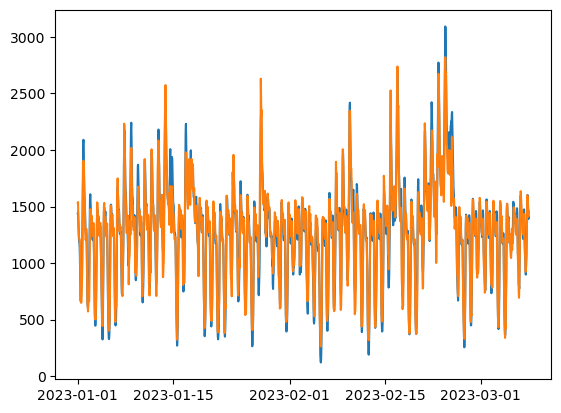

In [47]:
import matplotlib.pyplot as plt

plt.plot(df.loc[df['year'] == 2023, 'datetime'], y[test])
plt.plot(df.loc[df['year'] == 2023, 'datetime'], preds)
plt.show()

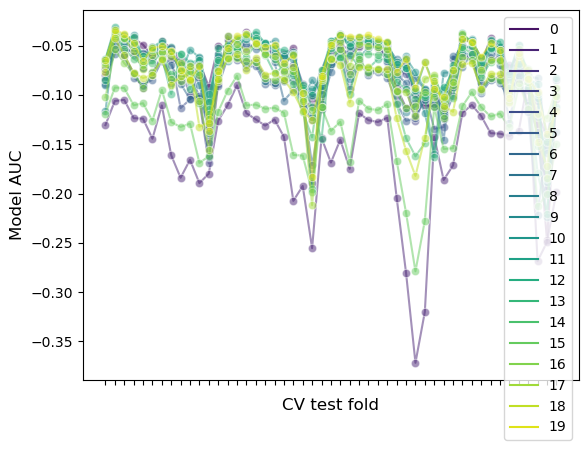

Correlation of models:
           0         1         2         3         4         5         6   \
0   1.000000  0.590851  0.781979  0.823523  0.858016  0.762782  0.699328   
1   0.590851  1.000000  0.578776  0.656949  0.490835  0.686463  0.593286   
2   0.781979  0.578776  1.000000  0.844330  0.816813  0.945010  0.769648   
3   0.823523  0.656949  0.844330  1.000000  0.832003  0.876256  0.855885   
4   0.858016  0.490835  0.816813  0.832003  1.000000  0.728038  0.735550   
5   0.762782  0.686463  0.945010  0.876256  0.728038  1.000000  0.766537   
6   0.699328  0.593286  0.769648  0.855885  0.735550  0.766537  1.000000   
7   0.879026  0.543613  0.866827  0.858731  0.892495  0.805231  0.769335   
8   0.809423  0.606647  0.987364  0.880465  0.808147  0.971449  0.768245   
9   0.914118  0.488583  0.760985  0.766317  0.850401  0.701221  0.689514   
10  0.945588  0.517805  0.851772  0.846301  0.906320  0.786146  0.737766   
11  0.719170  0.537590  0.785945  0.946107  0.764067  0.778723  

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test.*percentage.*")

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose(),#.iloc[:30],
    dashes=False,
    palette="viridis",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")